# Weakly Supervised Anomaly Detection with Classifier Guidance

This tutorial illustrates how to use MONAI Generative Models for training a 2D gradient-guided anomaly detection using DDIMs [1].

In summary, the tutorial will cover:
1. Loading and preprocessing a dataset (we extract the brain MRI dataset 2D slices from 3D volumes from the BraTS dataset)
2. Training a 2D diffusion model
3. Anomlay detection with the trained model

This method results in  anomaly heatmaps. It is weakly supervised. The information about labels is not fed to the model as segmentation masks, but as a scalar signal (is there an anomaly or not) which is used to guide the diffusion process.

During inference, the model is used to generate a counterfactual image, which is then compared to the original image. The difference between the two images is used to generate an anomaly heatmap.

[1] - Sanchez et al. [What is Healthy? Generative Counterfactual Diffusion for Lesion Localization](https://arxiv.org/abs/2207.12268). DGM 4 MICCAI 2022

## Setup imports

In [1]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
import os
import shutil
import tempfile
import time
from typing import Dict
import os
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import MedNISTDataset, DecathlonDataset
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
from monai.utils import first, set_determinism
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
torch.multiprocessing.set_sharing_strategy('file_system')
import sys
sys.path.append('/home/s2086085/RDS/GenerativeModels')
print('path', sys.path)
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from generative.inferers import DiffusionInferer

from generative.networks.nets.diffusion_model_unet import DiffusionModelUNet
from generative.networks.schedulers.ddim import DDIMScheduler
print_config()

/remote/rds/users/s2086085/miniconda3/envs/pytorch_monai/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


path ['/remote/rds/users/s2086085/GenerativeModels/tutorials/anomaly_detection', '/remote/rds/users/s2086085/GenerativeModels/tutorials/anomaly_detection', '/home/s2086085/RDS/counterfactual_ebm', '/home/s2086085/RDS/anomaly_detection', '/home/s2086085/RDS/deci/azua', '/remote/rds/users/s2086085/miniconda3/envs/pytorch_monai/lib/python310.zip', '/remote/rds/users/s2086085/miniconda3/envs/pytorch_monai/lib/python3.10', '/remote/rds/users/s2086085/miniconda3/envs/pytorch_monai/lib/python3.10/lib-dynload', '', '/home/s2086085/.local/lib/python3.10/site-packages', '/remote/rds/users/s2086085/miniconda3/envs/pytorch_monai/lib/python3.10/site-packages', '/remote/rds/users/s2086085/miniconda3/envs/pytorch_monai/lib/python3.10/site-packages/generative-0.1.0-py3.10.egg', '/remote/rds/users/s2086085/miniconda3/envs/pytorch_monai/lib/python3.10/site-packages/monai_weekly-1.2.dev2304-py3.10.egg', '/remote/rds/users/s2086085/miniconda3/envs/pytorch_monai/lib/python3.10/site-packages/wheel-0.38.4-py

## Setup data directory

In [2]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory

## Set deterministic training for reproducibility

In [3]:
set_determinism(42)

## Setup BRATS Dataset  - Extract 2D slices from 3D volumes

We now download the BraTS dataset and extract the 2D slices from the 3D volumes. The `slice_label` are used to indicate whether the slice contains an anomaly or not.

Here we use transforms to augment the training dataset, as usual:

1. `LoadImaged` loads the hands images from files.
2. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
3. `ScaleIntensityRangePercentilesd` Apply range scaling to a numpy array based on the intensity distribution of the input. Transform is very common with MRI images.


`get_batched_2d_axial_slices` is a utility function that extracts 2D slices from 3D volumes.


In [4]:
channel = 0  # 0 = Flair
assert channel in [0, 1, 2, 3], "Choose a valid channel"

train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image","label"]),
        transforms.EnsureChannelFirstd(keys=["image","label"]),
        transforms.Lambdad(keys=["image"], func=lambda x: x[channel, :, :, :]),
        transforms.AddChanneld(keys=["image"]),
        transforms.EnsureTyped(keys=["image","label"]),
        transforms.Orientationd(keys=["image","label"], axcodes="RAS"),
        transforms.Spacingd(
            keys=["image","label"],
            pixdim=(3.0, 3.0, 2.0),
            mode=("bilinear", "nearest"),
        ),
        transforms.CenterSpatialCropd(keys=["image","label"], roi_size=(64, 64, 64)),
        transforms.ScaleIntensityRangePercentilesd(keys="image", lower=0, upper=99.5, b_min=0, b_max=1),
        transforms.CopyItemsd(keys=["label"], times=1, names=["slice_label"]),
        transforms.Lambdad(keys=["slice_label"], func=lambda x: (x.reshape(x.shape[0], -1, x.shape[-1]).sum(1) > 0 ).float().squeeze()),
    ]
)

def get_batched_2d_axial_slices(data : Dict):
    images_3D = data['image']
    batched_2d_slices = torch.cat(images_3D.split(1, dim = -1)[10:-10], 0).squeeze(-1) # we cut the lowest and highest 10 slices, because we are interested in the middle part of the brain.
    slice_label = data['slice_label']
    slice_label = torch.cat(slice_label.split(1, dim = -1)[10:-10],0).squeeze()
    return batched_2d_slices, slice_label

<class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.


### Training Dataset

In [5]:

train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    section="training",  # validation
    cache_rate=0.0,  # you may need a few Gb of RAM... Set to 0 otherwise
    num_workers=4,
    download=False,  # Set download to True if the dataset hasnt been downloaded yet
    seed=0,
    transform=train_transforms,
)
print('len train data', len(train_ds))

train_loader_3D = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)
print(f'Image shape {train_ds[0]["image"].shape}')

data_2d_slices=[]
data_slice_label = []
check_data = first(train_loader_3D)
for i, data in enumerate(train_loader_3D):
    b2d, slice_label2d = get_batched_2d_axial_slices(data)
    data_2d_slices.append(b2d)
    data_slice_label.append(slice_label2d)
total_train_slices=torch.cat(data_2d_slices,0)
total_train_labels=torch.cat(data_slice_label,0)

print('total slices', total_train_slices.shape)
print('total lbaels', total_train_labels.shape)

len train data 388
Image shape torch.Size([1, 64, 64, 64])
total slices torch.Size([17072, 1, 64, 64])
total lbaels torch.Size([17072])


### Validation Dataset


In [6]:
val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    section="validation",  # validation
    cache_rate=0.0,  # you may need a few Gb of RAM... Set to 0 otherwise
    num_workers=4,
    download=False,  # Set download to True if the dataset hasnt been downloaded yet
    seed=0,
    transform=train_transforms,
)

val_loader_3D = DataLoader(val_ds, batch_size=1, shuffle=True, num_workers=4)
print(f'Image shape {val_ds[0]["image"].shape}')
print('len val data', len(val_ds))
data_2d_slices_val=[]
data_slice_label_val = []
for i, data in enumerate(val_loader_3D):
    b2d, slice_label2d = get_batched_2d_axial_slices(data)
    data_2d_slices_val.append(b2d)
    data_slice_label_val.append(slice_label2d)
total_val_slices=torch.cat(data_2d_slices_val,0)
total_val_labels=torch.cat(data_slice_label_val,0)

print('total slices', total_val_slices.shape)
print('total lbaels', total_val_labels.shape)

Image shape torch.Size([1, 64, 64, 64])
len val data 96
total slices torch.Size([4224, 1, 64, 64])
total lbaels torch.Size([4224])


## Define network, scheduler, optimizer, and inferer

At this step, we instantiate the MONAI components to create a DDIM, the UNET with conditioning, the noise scheduler, and the inferer used for training and sampling. We are using
the deterministic DDIM scheduler containing 1000 timesteps, and a 2D UNET with attention mechanisms.

The `attention` mechanism is essential for ensuring good conditioning and images manipulation here. 

An `embedding layer`, which is also optimised during training, is used in the original work because it was empirically shown to improve conditioning compared to a single scalar information.


In [7]:
device = torch.device("cuda")

model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=(64, 128, 128),
    attention_levels=(False, True, True),
    num_res_blocks=1,
    num_head_channels=16,
    with_conditioning=True,
    cross_attention_dim=64,
    ).to(device)
embed = torch.nn.Embedding(num_embeddings = 3, embedding_dim= 64, padding_idx=0).to(device)

scheduler = DDIMScheduler(
    num_train_timesteps=1000,
)
optimizer = torch.optim.Adam(params=list(model.parameters()) + list(embed.parameters()), lr=5e-5)

inferer = DiffusionInferer(scheduler)

## Training a diffusion model with classifier-free guidance

Epoch 0: 100%|█████████▉| 266/266.75 [00:54<00:00,  5.02it/s, loss=0.0189]clamping frac to range [0, 1]
Epoch 0: 100%|██████████| 267/266.75 [00:54<00:00,  4.88it/s, loss=0.0189]
4it [00:00, 20.78it/s]
Epoch 1: 100%|██████████| 267/266.75 [00:54<00:00,  4.88it/s, loss=0.0187]
4it [00:00, 20.77it/s]
Epoch 2: 100%|██████████| 267/266.75 [00:55<00:00,  4.85it/s, loss=0.018] 
4it [00:00, 20.83it/s]
Epoch 3: 100%|██████████| 267/266.75 [00:54<00:00,  4.88it/s, loss=0.0184]
4it [00:00, 20.53it/s]
Epoch 4: 100%|██████████| 267/266.75 [00:54<00:00,  4.92it/s, loss=0.018] 
4it [00:00, 11.78it/s]
Epoch 5: 100%|██████████| 267/266.75 [00:54<00:00,  4.87it/s, loss=0.0172]
4it [00:00, 13.08it/s]
Epoch 6: 100%|██████████| 267/266.75 [00:55<00:00,  4.84it/s, loss=0.0175]
4it [00:00, 16.40it/s]
Epoch 7: 100%|██████████| 267/266.75 [00:54<00:00,  4.89it/s, loss=0.017] 
4it [00:00, 20.78it/s]
Epoch 8: 100%|██████████| 267/266.75 [00:54<00:00,  4.88it/s, loss=0.0174]
4it [00:00, 15.99it/s]
Epoch 9: 100%|

train diffusion completed, total time: 2781.4672198295593.


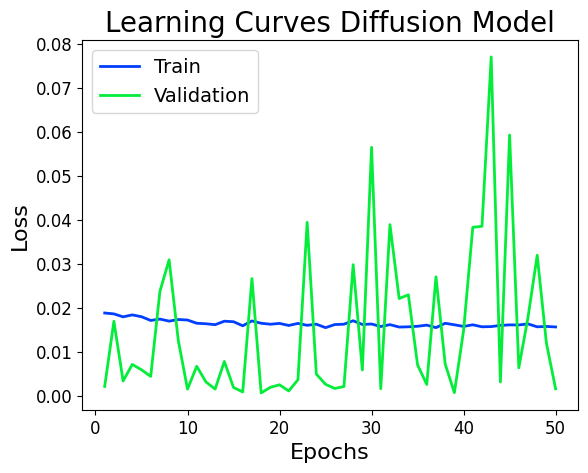

In [14]:
condition_dropout = 0.15
n_epochs = 50
batch_size = 64
val_interval = 1
epoch_loss_list = []
val_epoch_loss_list = []

train_diffusionmodel=False

scaler = GradScaler()
total_start = time.time()
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    indexes = list(torch.randperm(total_train_slices.shape[0]))  #shuffle training data new
    data_train = total_train_slices[indexes]  # shuffle the training data
    labels_train = total_train_labels[indexes]
    subset_2D = zip(data_train.split(batch_size), labels_train.split(batch_size))
    subset_2D_val = zip(total_val_slices.split(1), total_val_labels.split(1))  # validation data

    progress_bar = tqdm(enumerate(subset_2D), total=len(indexes)/batch_size)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, (images, classes) in progress_bar:
        images, classes = images.to(device), classes.to(device)
        classes += 1 # convert to 1,2 instead of 0, 1 for the embedding layer, 0 corresponds to dropout
        if np.random.uniform() < condition_dropout:
            classes = torch.zeros_like(classes).to(device)  # 15% of the time, class conditioning dropout
        class_embedding = embed(classes.type(torch.cuda.LongTensor)).unsqueeze(1) # cross attention expects shape [batch size, sequence length, channels]
        optimizer.zero_grad(set_to_none=True)
        timesteps = torch.randint(0, 1000, (len(images),)).to(device)  # pick a random time step t

        with autocast(enabled=True):
            # Generate random noise
            noise = torch.randn_like(images).to(device)

            # Get model prediction
            noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps, condition=class_embedding)

            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        progress_bar.set_postfix(
            {
                "loss": epoch_loss / (step + 1),
            }
        )
    epoch_loss_list.append(epoch_loss / (step + 1))
    
    if (epoch) % val_interval == 0:
        model.eval()
        val_epoch_loss = 0
        progress_bar_val = tqdm(enumerate(subset_2D_val))
        progress_bar.set_description(f"Epoch {epoch}")
        for step, (images, classes) in progress_bar_val:
            images, classes = images.to(device), classes.to(device)
            classes += 1 # convert to 1,2 instead of 0, 1
            class_embedding = embed(classes.type(torch.cuda.LongTensor)).unsqueeze(1) # cross attention expects shape [batch size, sequence length, channels]
            
            timesteps = torch.randint(0, 1000, (len(images),)).to(device)
            with torch.no_grad():
                with autocast(enabled=True):
                    noise = torch.randn_like(images).to(device)
                    noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps, condition=class_embedding)
                    val_loss = F.mse_loss(noise_pred.float(), noise.float())

            val_epoch_loss += val_loss.item()
            progress_bar.set_postfix(
                {
                    "val_loss": val_epoch_loss / (step + 1),
                }
            )
            if step > 3:
                break
        val_epoch_loss_list.append(val_epoch_loss / (step + 1))

total_time = time.time() - total_start

print(f"train diffusion completed, total time: {total_time}.")

plt.style.use("seaborn-bright")
plt.title("Learning Curves Diffusion Model", fontsize=20)
plt.plot(np.linspace(1, n_epochs, n_epochs), epoch_loss_list, color="C0", linewidth=2.0, label="Train")
plt.plot(
    np.linspace(val_interval, n_epochs, int(n_epochs / val_interval)),
    val_epoch_loss_list,
    color="C1",
    linewidth=2.0,
    label="Validation",
)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.show()

## Generate synthetic data
(Only for verifying the model and classifier guidance is working)

100%|██████████| 100/100 [00:03<00:00, 30.78it/s]


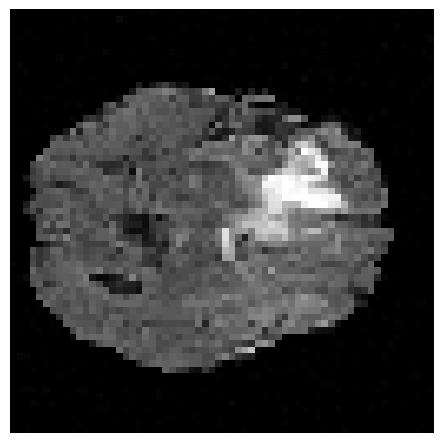

In [15]:
model.eval()
scheduler.clip_sample = True
guidance_scale = 3
conditioning = torch.cat([torch.zeros(1).long(), 2*torch.ones(1).long()], dim=0).to(device) # 2*torch.ones(1).long() is the class label for the UNHEALTHY (tumor) class
class_embedding = embed(conditioning).unsqueeze(1) # cross attention expects shape [batch size, sequence length, channels]
noise = torch.randn((1, 1, 64, 64))
noise = noise.to(device)
scheduler.set_timesteps(num_inference_steps=100)
progress_bar = tqdm(scheduler.timesteps)
for t in progress_bar:
    with autocast(enabled=True):
        with torch.no_grad():
            noise_input = torch.cat([noise] * 2)
            model_output = model(noise_input, timesteps=torch.Tensor((t,)).to(noise.device), context=class_embedding)
            noise_pred_uncond, noise_pred_text = model_output.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    noise, _ = scheduler.step(noise_pred, t, noise)

plt.style.use("default")
plt.imshow(noise[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

# Image-to-Image Translation to a Healthy Subject
We pick a diseased subject of the validation set as input image. We want to translate it to its healthy reconstruction.

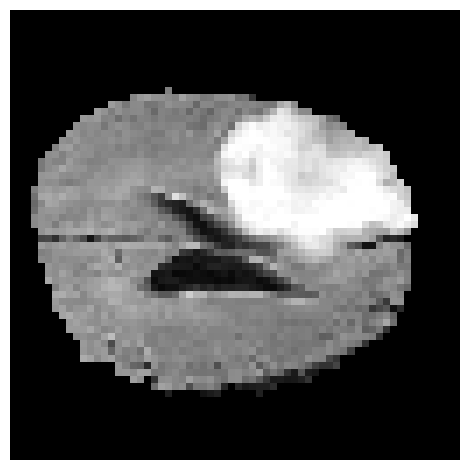

input label:  tensor(1.)


In [16]:

idx = 250
inputimg = total_val_slices[idx][0,...]  # Pick an input slice of the validation set to be transformed   
inputlabel= total_val_labels[idx]        # Check whether it is healthy or diseased

plt.figure("input"+str(inputlabel))
plt.imshow(inputimg, vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

model.eval();
print("input label: ", inputlabel)


### The image-to-image translation has two steps

1. Encoding the input image into a latent space with the reversed DDIM sampling scheme
2. Sampling from the latent space using gradient guidance towards the desired class label y=1 (healthy)

In order to sample using gradient guidance, we first need to encode the input image in noise by using the reversed DDIM sampling scheme.
We define the number of steps in the noising and denoising process by L.

In [45]:
model.eval()


guidance_scale = 3
T = 500 # 500
L = int(T * 0.35) # 0.25

current_img = inputimg[None,None,...].to(device)
scheduler.set_timesteps(num_inference_steps=T)

## Encoding

scheduler.clip_sample = False
class_embedding = embed(torch.zeros(1).long().to(device)).unsqueeze(1)
progress_bar = tqdm(range(L))   #go back and forth L timesteps
for i in progress_bar:  #go through the noising process
    t = i
    with autocast(enabled=False):
        with torch.no_grad():
            model_output = model(current_img, timesteps=torch.Tensor((t,)).to(current_img.device), context=class_embedding)
    current_img, _ = scheduler.reversed_step(model_output, t, current_img)
    progress_bar.set_postfix({"timestep input": t})

latent_img = current_img

## Decoding

conditioning = torch.cat([torch.zeros(1).long(), torch.ones(1).long()], dim=0).to(device)
class_embedding = embed(conditioning).unsqueeze(1)
progress_bar = tqdm(range(L))   #go back and forth L timesteps

for i in progress_bar:  #go through the denoising process
    t = L - i
    with autocast(enabled=True):
        current_img_double = torch.cat([current_img] * 2)
        with torch.no_grad():
            model_output = model(current_img_double, timesteps=torch.Tensor([t,t]).to(current_img.device), context=class_embedding)
            noise_pred_uncond, noise_pred_text = model_output.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
            
        current_img, _ = scheduler.step(noise_pred, t, current_img)
    progress_bar.set_postfix({"timestep input": t})
    torch.cuda.empty_cache()

100%|██████████| 175/175 [00:08<00:00, 20.39it/s, timestep input=1] 


### Visualize anomaly map

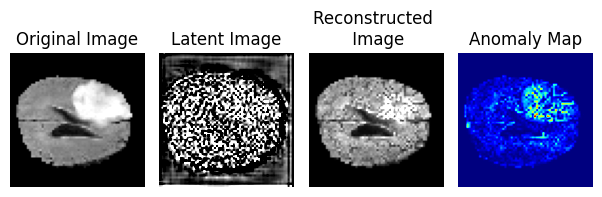

In [46]:
def visualize(img):
    _min = img.min()
    _max = img.max()
    normalized_img = (img - _min)/ (_max - _min)
    return normalized_img

diff=abs(inputimg.cpu()-current_img[0, 0].cpu()).detach().numpy()
row = 4
plt.style.use("default")

ax = plt.subplot(1,row,2)
ax.set_title("Latent Image")
ax.imshow(latent_img[0, 0].cpu().detach().numpy(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")


ax = plt.subplot(1,row,3)
ax.set_title("Reconstructed \n Image")
ax.imshow(current_img[0, 0].cpu().detach().numpy(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")


ax = plt.subplot(1,row,4)
ax.set_title("Anomaly Map")
ax.imshow(diff, vmin=0, vmax=1, cmap="jet")
plt.tight_layout()
plt.axis("off")


ax = plt.subplot(1,row,1)
ax.set_title("Original Image")
ax.imshow(inputimg, vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()
